In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from RBFlib import RBF
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from simplification.cutil import simplify_coords_vw
import json


In [2]:
def loocv(x, y, model):
    warnings.filterwarnings("ignore")
    """х - массив точек.
    у - массив значений.
    возвращаяет R2 LOOCV модели"""
    pred = []
    loo = LeaveOneOut()
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)
    for i, (train_index, test_index) in enumerate(loo.split(x)):
        model.fit(x[train_index], y[train_index])
        res = model.predict(np.array(x[test_index]))
        pred.append(float(res))
    return r2_score(y, pred)

In [3]:
def normalize(mas, coef):
    '''Возвращает нормализированный массив от 0 до 1, умноженный на коэффициент coef'''
    mas=np.array(mas)
    mas_min = mas.min()
    mas_max = mas.max()
    if mas_max - mas_min == 0:
        mas_norm = np.zeros_like(mas)  
    else:
        mas_norm = coef*(mas - mas_min) / (mas_max - mas_min)
    return mas_norm

def denormalize(mas_norm, min,max, coef):
    '''Возвращает ДЕнормализированный массив, mas_norm - нормализированный от 0 до 1 и умноженный на коэффициент coef'''
    mas_norm=np.array(mas_norm)/coef

    if max - min == 0:
        return np.full_like(mas_norm, min)
    else:
        mas_denorm = min + mas_norm * (max - min)
        return mas_denorm

In [4]:
def calc_surface(
    data: dict,
    coordinates: dict,
    borders=None,
    resolution=100,
    model=RBF(),
    validation=False,
    normalize=True,
    gap=10,
):
    """
    Создает интерполированную карту значений на основе заданных данных и координат.
    Функция использует машинное обучение для интерполяции значений между известными точками
    и генерирует регулярную сетку значений, которая может быть использована для визуализации
    карты изолиний, тепловой карты или других типов пространственного анализа.
    Параметры:
    -----------
    data : dict
        Словарь, где ключи - идентификаторы точек, значения - числовые значения в этих точках
    coordinates : dict
        Словарь, где ключи - те же идентификаторы точек, значения - кортежи координат (x, y)
    resolution : int, optional, default=100
        Разрешение выходной сетки (количество точек по каждой оси)
    model : sklearn estimator, optional, default=RBF()
        Модель машинного обучения для интерполяции значений
    normalize : bool, optional, default=True
        Флаг нормализации координат перед обучением модели
    gap : int, optional, default=10
        Процент расширения границ карты относительно крайних точек (для отступа)

    Возвращает:
    -----------

    aa : numpy.ndarray
        2D массив координат X сетки (meshgrid)
    bb : numpy.ndarray
        2D массив координат Y сетки (meshgrid)
    z_map : numpy.ndarray
        2D массив интерполированных значений Z, соответствующих координатам сетки

    Пример использования:
    --------------------

    >>> data = {'point1': 10, 'point2': 20, 'point3': 15}

    >>> coordinates = {'point1': (0, 0), 'point2': (10, 10), 'point3': (5, 3)}

    >>> xx, yy, zz = calc_surface(data, coordinates, resolution=50)

    """

    X = np.array(
        list(coordinates.values())
    )  # X- массив координат [[x1.y1].[x2.y2]...]       

    x, y = X.T[0], X.T[1]  # координаты X и Y отдельно

    if borders!=None:
        xb=np.array(borders).T[0]
        yb=np.array(borders).T[1]
        bounds_x = [min(xb), max(xb)]
        bounds_y = [min(yb), max(yb)]
    else:
        bounds_x = [min(x), max(x)]
        bounds_y = [min(y), max(y)]
    delta_x = (bounds_x[1] - bounds_x[0]) * gap / 100
    delta_y = (bounds_y[1] - bounds_y[0]) * gap / 100

    resolution = int(resolution)

    aa, bb = np.meshgrid(
        np.linspace(bounds_x[0] - delta_x, bounds_x[1] + delta_x, resolution),
        np.linspace(bounds_y[0] - delta_y, bounds_y[1] + delta_y, resolution),
    )

    if borders==None:
        borders=[[aa.min(),bb.min()],[aa.min(),bb.max()],[aa.max(),bb.max()],[aa.max(),bb.min()]]


    xx = np.vstack([aa.ravel(), bb.ravel()]).T

    if normalize:
        scaler = StandardScaler()
        learn_X = scaler.fit_transform(np.array(list(coordinates.values())))
        pred_xx = scaler.fit_transform(xx)

    else:
        learn_X = X
        pred_xx = xx

    learn_Z = np.array(list(data.values())).reshape(-1, 1)  # массив значений
    model.fit(learn_X, learn_Z)
    z_map = model.predict(pred_xx).reshape(resolution, resolution)
    if validation:
        r2 = loocv(X, learn_Z, model)
        # print("R2-score: ", r2)
        return aa, bb, z_map,borders,r2
    else:
        return aa, bb, z_map,borders,'-'

In [5]:
def create_map(
    xx, yy, zz,levels=10
):
    countr = plt.contourf(xx, yy, zz, levels=levels)
    plt.close()

    polygons = []
    for i, level_segs in enumerate(countr.allsegs):
        z_val = float(countr.cvalues[i])
        # Замена "extend"-значений
        if z_val < -1e200:
            z_val = countr.levels[0]
        elif z_val > 1e200:
            z_val = countr.levels[-1]
        for seg in level_segs:
            seg_3d = np.column_stack([seg, np.full(len(seg), z_val)])
            polygons.append(seg_3d)

    return polygons

In [6]:
def polygon_area(poly_2d):
    """Возвращает площадь полигона (может быть 0 для вырожденных)."""
    try:
        return float(Polygon(poly_2d).area)
    except Exception:
        return 0.0
    

def relative_tolerance(poly_2d, rel=0.01):
    """
    Возвращает tolerance для Visvalingam–Whyatt.
    rel — доля от площади самого полигона (не bbox!).
    """
    area = polygon_area(poly_2d)
    if area <= 0:
        # Если полигон вырожденный — используем bbox-площадь
        minx, miny, maxx, maxy = Polygon(poly_2d).bounds
        area = (maxx - minx) * (maxy - miny) or 1e-16
    return area * rel


In [7]:
def simplify_polygons(polygons, z_values,tolerance=0.1):
    simplified = []
    for poly, z in zip(polygons, z_values):
        if len(poly) < 3:
            continue  # пропускаем слишком короткие

        # Извлекаем только x, y
        xy = np.array(poly)[:, :2]  # берём первые два столбца

        # Упрощаем (алгоритм Visvalingam–Whyatt)
        xy_simpl = simplify_coords_vw(xy.tolist(), tolerance)

        # Добавляем обратно z (одинаковое для всех точек полигона)
        poly_simpl = [[x, y, z] for x, y in xy_simpl]

        # Убедимся, что полигон замкнут (опционально)
        if len(poly_simpl) >= 3 and poly_simpl[0] != poly_simpl[-1]:
            poly_simpl.append(poly_simpl[0])

        simplified.append(poly_simpl)

    return simplified

In [8]:
def clip_polygons(polygons_coords, boundary_coords):
    boundary = Polygon(boundary_coords)
    clipped_polygons = []
    for coords in polygons_coords:
        poly = Polygon(coords)
        if not poly.is_valid:
            poly = poly.buffer(0)  # попытка исправить невалидную геометрию
        intersection = poly.intersection(boundary)
        if intersection.is_empty:
            continue
        if isinstance(intersection, Polygon):
            if not intersection.is_empty and intersection.exterior.coords:
                clipped_polygons.append(list(intersection.exterior.coords))
        elif isinstance(intersection, MultiPolygon):
            for part in intersection.geoms:
                if not part.is_empty and part.exterior.coords:
                    clipped_polygons.append(list(part.exterior.coords))
    return clipped_polygons

In [9]:
def plot_clipped_polygons(clipped_polygons, boundary_coords=None, save_pic=False,):

    fig, ax = plt.subplots(figsize=(8, 8))

    # Извлекаем координаты и значения z
    patches = []
    z_values = []

    for coords in clipped_polygons:
        # if len(coords) < 3:
        #     continue
        # Извлекаем x, y и z
        xy = [(x, y) for x, y, z in coords]
        z_vals = [z for x, y, z in coords]
        z_mean = z_vals[0]
        patches.append(MplPolygon(xy, closed=True))
        z_values.append(z_mean)

    # if not patches:
    #     print("Нет валидных полигонов для отрисовки.")
    #     return

    # Создаём коллекцию и задаём цвета
    p = PatchCollection(patches, cmap='viridis', alpha=1, edgecolor='black', linewidth=0.5)
    p.set_array(np.array(z_values))
    ax.add_collection(p)

    # Отрисовка границы (если задана)
    if boundary_coords is not None and len(boundary_coords) >= 3:
        boundary_xy = [(x, y) for x, y, *_ in boundary_coords]
        boundary_patch = MplPolygon(boundary_xy, closed=True,
                                    edgecolor='red', facecolor='none',
                                    linewidth=2, linestyle='-')
        ax.add_patch(boundary_patch)

    # Настройки осей
    # ax.set_aspect('equal')
    ax.autoscale_view()

    plt.colorbar(p, ax=ax, shrink=0.8)
    plt.grid(True, linestyle=':', alpha=0.5)
    fig.tight_layout()
    if save_pic:
        plt.savefig("map.png")
    else:
        plt.show()
    plt.close()

In [10]:
def create_json_polygons(polygons, coef=0,tolerance=0.1,description="контур", postfix=""):
    '''
    Формирует список словарей в формате JSON для передачи или сохранения контурных полигонов.
    Каждый элемент списка представляет собой объект с идентификатором, названием,
    координатами полигона и описанием, содержащим соответствующее значение из списка `values`.

    Args:
        polygons (list of array-like): Список полигонов, где каждый полигон — это массив
            координат (обычно в формате [[x1, y1, z1], [x2, y2, z2], ...]).
        values (list of float): Список числовых значений, соответствующих каждому полигону.
            Используется в описании контура.
        description (str, optional): Базовое текстовое описание, вставляемое в поле
            "description". По умолчанию "контур".
        postfix (str, optional): Дополнительный суффикс (например, единица измерения),
            добавляемый к значению в описании. По умолчанию пустая строка.

    Returns:
        list of dict: Список словарей, каждый из которых содержит поля:
            - "id": уникальный идентификатор вида "contour-0", "contour-1", ...
            - "name": название вида "Контур 0", "Контур 1", ...
            - "coordinates": исходный массив координат полигона
            - "description": строка вида "{description} {value:.2f} {postfix}"
    '''
    json_list = []

    z_orig=[]
    for coords in polygons:
        z_orig.append(coords[0][2])
    
    # Определяем, какие координаты использовать в выводе
    if coef != 0:
        z_norm = normalize(z_orig, coef).tolist()
        # Создаём копию полигонов с обновлённым z
        polygons_norm=simplify_polygons(polygons,z_norm,tolerance)
    else:
        z_norm=z_orig
        polygons_norm=simplify_polygons(polygons,z_norm,tolerance)

    plot_clipped_polygons(polygons_norm,save_pic=True)
    for i in range(len(polygons)):
        json_list.append(
            {
                "id": f"contour-{i}",
                "name": f"Контур {i}",
                "coordinates": list(polygons_norm[i]),
                "description": f"{description} {z_orig[i]:.2f} {postfix}",
            }
        )
    with open('output.json', 'w', encoding='utf-8') as f:
        json.dump(json_list, f, ensure_ascii=False, indent=2)
    return json.dumps(json_list, ensure_ascii=False, indent=2)

In [11]:
def prepare_polygon(polygons, coef=0,tolerance=0.1):
    z_orig=[]
    for coords in polygons:
        z_orig.append(coords[0][2])
    
    # Определяем, какие координаты использовать в выводе
    if coef != 0:
        z_norm = normalize(z_orig, coef).tolist()
        polygons_simple=simplify_polygons(polygons,z_norm,tolerance)
    else:
        z_norm=z_orig
        polygons_simple=simplify_polygons(polygons,z_norm,tolerance)

    polygons_2d=[]
    for poly in polygons_simple:
        xy = [[x, y] for x, y, z in poly]
        if xy and xy[0] != xy[-1]:
            xy.append(xy[0])
        polygons_2d.append(xy)
    return polygons_2d, z_orig,z_norm

In [12]:
def create_geojson_polygons(polygons_2d, z_orig,z_norm,description="контур", postfix=""):
    features=[]

    for i, (poly_2d, z,z_true) in enumerate(zip(polygons_2d, z_norm,z_orig)):

        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [poly_2d]  # один внешний контур
            },
            "properties": {
                "id": f"contour-{i}",
                "name": f"Контур {i}",
                "description": f"{description} {z_true:.2f} {postfix}".strip(),
                "level": float(z)
            }
        }
        features.append(feature)

    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    return geojson 

In [13]:
def add_z_to_polygons(polygons_2d, z_values):
    """
    Добавляет z-координату к 2D-полигонам.

    Параметры:
        polygons_2d (list of list of [x, y]): Список 2D-полигонов.
        z_values (list of float): Список значений z (по одному на полигон).

    Возвращает:
        list of list of [x, y, z]: Список 3D-полигонов.
    """
    if len(polygons_2d) != len(z_values):
        raise ValueError("Количество полигонов и значений z должно совпадать.")

    polygons_3d = []
    for poly, z in zip(polygons_2d, z_values):
        # Преобразуем каждую точку [x, y] → [x, y, z]
        poly_3d = [[x, y, z] for x, y in poly]
        polygons_3d.append(poly_3d)

    return polygons_3d

In [14]:
def generate_surface(
    nums, x_range=(-6, 6), y_range=(-6, 6), grid_resolution=1000,peaks_count=3
):
    """
    Упрощенная функция: генерирует поверхность и возвращает только nums точек из этой поверхности.

    Возвращает:
    - points: массив формы (nums, 3) с координатами [x, y, z]
    """

    x = np.linspace(x_range[0], x_range[1], grid_resolution)
    y = np.linspace(y_range[0], y_range[1], grid_resolution)
    X, Y = np.meshgrid(x, y)

    # Базовая поверхность
    Z = np.full_like(X, 0)

    peaks=[]
    for i in range(peaks_count):
        peaks.append([random.uniform(x_range[0], x_range[1]),random.uniform(y_range[0], y_range[1]),40])

    for px, py, height in peaks:
        sigma = (x_range[1]-x_range[0])/10  # ширина пика 
        distance_squared = (X - px)**2 + (Y - py)**2
        peak = height * np.exp(-distance_squared / (2 * sigma**2))
        Z += peak

    all_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
    indices = np.random.choice(len(all_points), nums, replace=False)
    selected_points = all_points[indices]

    return selected_points

In [15]:
def count_vertices(polygons):
    """Считает общее число вершин во всех полигонах."""
    return sum(len(poly) for poly in polygons)

def compare_vertices(*polygon_sets):
    """
    Сравнивает количество вершин в нескольких наборах полигонов.
    
    Аргументы:
        *polygon_sets: несколько списков полигонов (2D или 3D).
        
    Возвращает:
        dict: Ключи — 'set_0', 'set_1', ..., значения — число вершин.
              Дополнительно: 'reduction_from_first' — процент сокращения
              относительно первого набора (для удобства сравнения).
    """
    counts = [sum(len(poly) for poly in polys) for polys in polygon_sets]
    
    result = {f"set_{i}": count for i, count in enumerate(counts)}
    
    # Добавим процентное сокращение относительно первого набора (если их >1)
    if len(counts) > 1 and counts[0] > 0:
        result["reduction_from_first (%)"] = [
            round((counts[0] - c) / counts[0] * 100, 2) for c in counts
        ]
    
    return result

пример использования

In [16]:
surface_points = generate_surface(50, (41,41.1), (41,41.1))

# словари с точками на поверхности
coordinates, values = {}, {} 
for i in range(len(surface_points)):
    coordinates[str(i)] = surface_points[i][0:2]
    values[str(i)] = surface_points[i][2]
borders=[[41,41],[41.01,41.08],[41.1,41.07],[41.08,41.01]]

5.950000000000083e-09
границы области карты
[[41, 41], [41.01, 41.08], [41.1, 41.07], [41.08, 41.01]]
R2-score:  0.5167824158068861
уменьшение размера полигонов
{'set_0': 6777, 'set_1': 3265, 'set_2': 1803, 'reduction_from_first (%)': [0.0, 51.82, 73.4]}
оригинальная карта


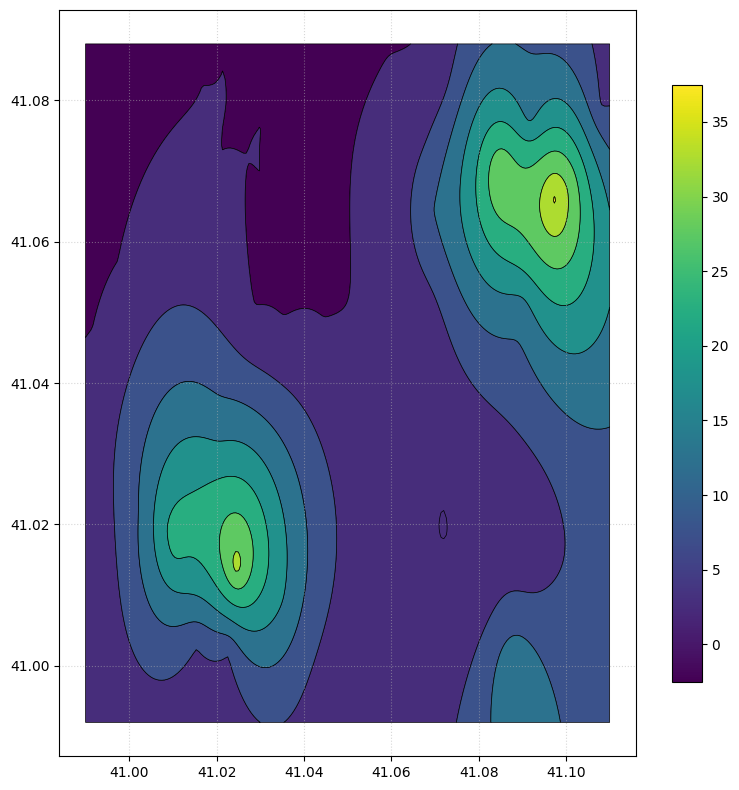

обрезанная по границам карта


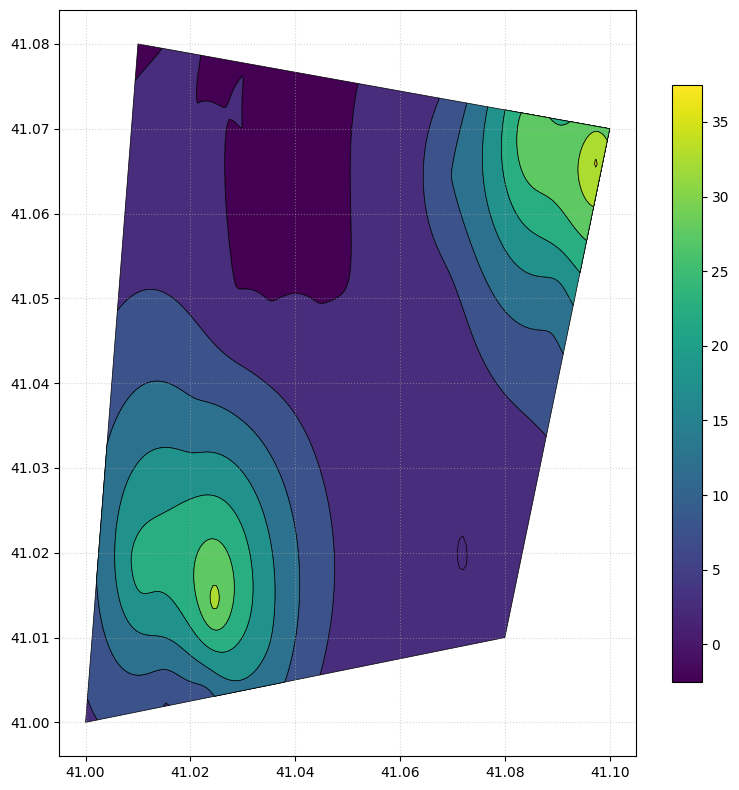

упрощенна обрезанная карта


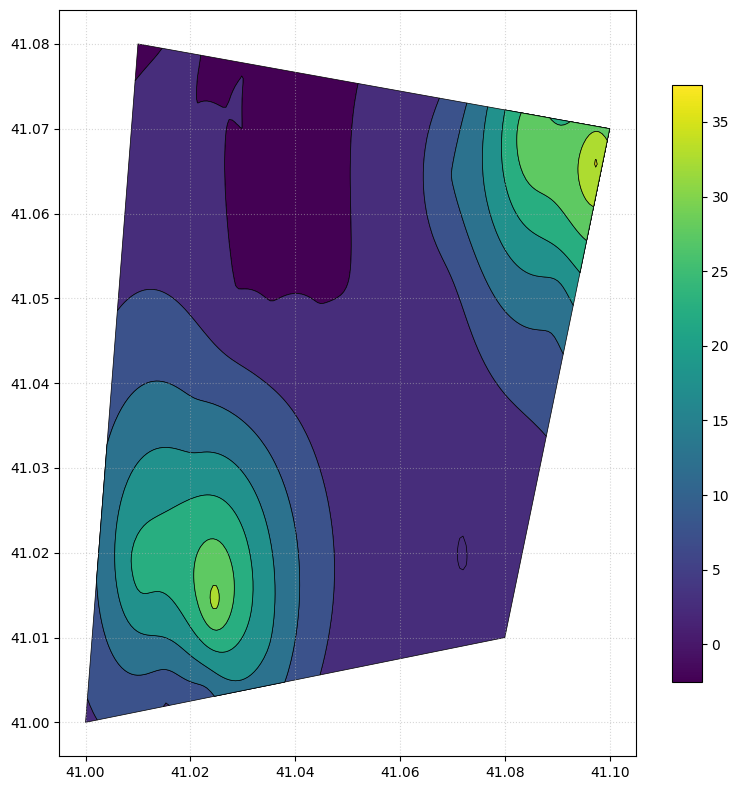

'{\n  "type": "FeatureCollection",\n  "features": [\n    {\n      "type": "Feature",\n      "geometry": {\n        "type": "Polygon",\n        "coordinates": [\n          [\n            [\n              41.07175005854534,\n              41.01805025125628\n            ],\n            [\n              41.07140703517588,\n              41.01817366406559\n            ],\n            [\n              41.07119639560582,\n              41.018532663316584\n            ],\n            [\n              41.07102766279091,\n              41.019015075376885\n            ],\n            [\n              41.07094817734645,\n              41.019497487437185\n            ],\n            [\n              41.07093933354305,\n              41.019979899497486\n            ],\n            [\n              41.07099120264948,\n              41.020462311557786\n            ],\n            [\n              41.07110037233099,\n              41.020944723618086\n            ],\n            [\n              41.0712

In [19]:
def example(
    coordinates: dict,
    values: dict,
    borders=None,
    model=RBF(),
    validation=False,
    levels=7,
    rel=1e-6,
    resolution=200,
    coef=100,
    description="Показатель",
    postfix="",
    show=False,
    savejson=False,
    info=False
):

    x, y, z ,borders,r2= calc_surface(
        values,
        coordinates,
        borders=borders,
        model=model,
        resolution=resolution,
        normalize=True,
        validation=validation,
        gap=10,
    )
    polygons = create_map(x, y, z, levels=levels)

    if borders != None:
        clpolygons = clip_polygons(polygons, borders)
    else:
        clpolygons = polygons
    # вывод обрезаного по границам полигона
    rel_tolerance=relative_tolerance(borders,rel)
    poly_2d, z_orig, z_norm = prepare_polygon(
        clpolygons, coef=coef, tolerance=rel_tolerance
    )
    print(rel_tolerance)
    geojson=create_geojson_polygons(poly_2d, z_orig, z_norm,description=description,postfix=postfix)


    if info:
        print("границы области карты")
        print(borders)
        print("R2-score: ", r2)
        print("уменьшение размера полигонов")
        print(compare_vertices(polygons,clpolygons,poly_2d))

    if show:
        print('оригинальная карта')
        plot_clipped_polygons(polygons)
        print('обрезанная по границам карта')
        plot_clipped_polygons(clpolygons)
        print('упрощенна обрезанная карта')
        simple_polygon = add_z_to_polygons(poly_2d, z_orig)
        plot_clipped_polygons(simple_polygon)

    if savejson:
        with open('output.geojson', 'w', encoding='utf-8') as f:
            json.dump(geojson, f, ensure_ascii=False, indent=2)

  


    return json.dumps(geojson, ensure_ascii=False, indent=2)
    

#просто получить geojson
example(coordinates, values,borders,show=True,validation=True,info=True,savejson=True)